In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
sheet_names = ["Na22", "Cs", "Co", "Schutz", "Nackt", "K2CO3", "Melke die Molke", "Uranoxid", "Thor", "Pilze nur Pilze"]
sheets = [pd.read_excel("RAD.xlsx", sheet_name=name) for name in sheet_names]

sheets

[       n_A  N_A
 0        0    6
 1        1   14
 2        2    9
 3        3    7
 4        4    3
 ...    ...  ...
 1019  1019    0
 1020  1020    0
 1021  1021    0
 1022  1022    0
 1023  1023   91
 
 [1024 rows x 2 columns],
        n_A  N_A
 0        0   25
 1        1   38
 2        2   32
 3        3   22
 4        4   17
 ...    ...  ...
 1019  1019    0
 1020  1020    0
 1021  1021    0
 1022  1022    0
 1023  1023   79
 
 [1024 rows x 2 columns],
        n_A  N_A
 0        0    2
 1        1    3
 2        2    0
 3        3    1
 4        4    0
 ...    ...  ...
 1019  1019    0
 1020  1020    0
 1021  1021    0
 1022  1022    0
 1023  1023  103
 
 [1024 rows x 2 columns],
       n_A#1  N_A#1
 0         0      2
 1         1      9
 2         2      5
 3         3      2
 4         4      1
 ...     ...    ...
 1019   1019      0
 1020   1020      1
 1021   1021      0
 1022   1022      0
 1023   1023   1009
 
 [1024 rows x 2 columns],
       n_A#1  N_A#1
 0         0    

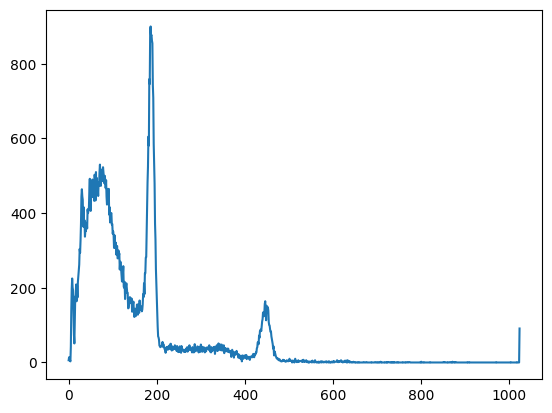

In [13]:
plt.plot(sheets[0]["n_A"], sheets[0]["N_A"])